Copyright (c) 2015-2017 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 5 - Compressing Data via Dimensionality Reduction

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -p numpy,scipy,matplotlib,sklearn

Sebastian Raschka 
last updated: 2017-08-30 

numpy 1.13.1
scipy 0.19.1
matplotlib 2.0.2
sklearn 0.19.0


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

<br>
<br>

### Overview

- [Unsupervised dimensionality reduction via principal component analysis 128](#Unsupervised-dimensionality-reduction-via-principal-component-analysis-128)
  - [Total and explained variance](#Total-and-explained-variance)
  - [Feature transformation](#Feature-transformation)
  - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
- [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting samples onto the new feature space](#Projecting-samples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
- [Using kernel principal component analysis for nonlinear mappings](#Using-kernel-principal-component-analysis-for-nonlinear-mappings)
  - [Kernel functions and the kernel trick](#Kernel-functions-and-the-kernel-trick)
  - [Implementing a kernel principal component analysis in Python](#Implementing-a-kernel-principal-component-analysis-in-Python)
    - [Example 1 – separating half-moon shapes](#Example-1:-Separating-half-moon-shapes)
    - [Example 2 – separating concentric circles](#Example-2:-Separating-concentric-circles)
  - [Projecting new data points](#Projecting-new-data-points)
  - [Kernel principal component analysis in scikit-learn](#Kernel-principal-component-analysis-in-scikit-learn)
- [Summary](#Summary)

<br>
<br>

In [3]:
from IPython.display import Image
%matplotlib inline

In [4]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Unsupervised dimensionality reduction via principal component analysis

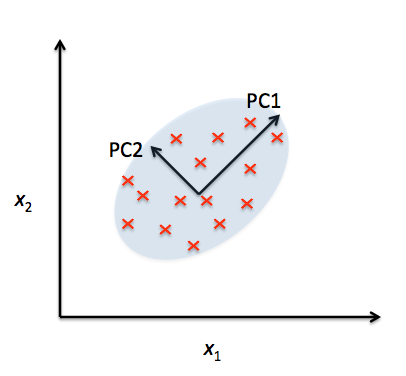

In [5]:
Image(filename='/home/parrondo/projects/development/python-machine-learning-book/github/parrondo/python-machine-learning-book/code/ch05/images/05_01.png', width=400) 

In [6]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

#Data set diectory
os.environ["DATA_PATH"] = "/home/parrondo/projects/research/ejemplo/data"
#load data
inputfile = os.path.join(os.environ['DATA_PATH'],'raw','2017week32','numerai_datasets','numerai_training_data.csv')
print("inputfile: ",inputfile)
dataframe = pd.read_csv(inputfile) # reads the csv and creates the dataframe called "dataframe"
dataframe.head()

inputfile:  /home/parrondo/projects/research/ejemplo/data/raw/2017week32/numerai_datasets/numerai_training_data.csv


,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,119763,era1,train,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,...,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567,0
1,45906,era1,train,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,...,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617,1
2,139896,era1,train,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,...,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855,0
3,116826,era1,train,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,...,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122,1
4,28656,era1,train,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,...,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677,1


In [7]:
dataframe.corr()

,id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
id,1.000000,0.000516,-0.000161,-0.000828,0.001729,0.000995,-0.000888,-0.001705,-0.000633,0.002205,...,0.000907,-0.001856,-0.001323,0.000909,-0.000713,-0.001125,-0.000711,-0.000693,-0.000598,0.003633
feature1,0.000516,1.000000,0.326717,-0.778413,0.588383,0.524918,-0.328860,0.201881,-0.945974,0.490422,...,0.881462,-0.395741,-0.000474,0.873620,-0.876611,-0.755403,0.312857,-0.685987,-0.198138,0.000675
feature2,-0.000161,0.326717,1.000000,-0.738175,0.843964,0.723536,0.489931,-0.256211,-0.262308,-0.472720,...,0.641691,-0.345659,0.221913,0.574954,-0.681600,-0.749202,-0.098831,-0.844166,-0.962432,-0.014065
feature3,-0.000828,-0.778413,-0.738175,1.000000,-0.906656,-0.928212,-0.156903,0.345072,0.613568,-0.222054,...,-0.979176,0.741818,0.211375,-0.952447,0.982656,0.992738,0.162953,0.811425,0.668620,0.008439
feature4,0.001729,0.588383,0.843964,-0.906656,1.000000,0.882611,0.313064,-0.399929,-0.505344,-0.019622,...,0.866666,-0.658962,-0.037118,0.790839,-0.868328,-0.942390,-0.118571,-0.887026,-0.844860,-0.013406
feature5,0.000995,0.524918,0.723536,-0.928212,0.882611,1.000000,0.402002,-0.651543,-0.316347,0.154970,...,0.857429,-0.879494,-0.397046,0.814676,-0.849104,-0.937495,-0.425427,-0.655364,-0.708804,-0.012222
feature6,-0.000888,-0.328860,0.489931,-0.156903,0.313064,0.402002,1.000000,-0.568612,0.396509,-0.497930,...,0.048317,-0.307727,-0.136844,-0.005779,-0.044529,-0.196344,-0.473483,-0.093739,-0.474064,-0.002724
feature7,-0.001705,0.201881,-0.256211,0.345072,-0.399929,-0.651543,-0.568612,1.000000,-0.427376,-0.136367,...,-0.212906,0.813281,0.741927,-0.214090,0.182136,0.374331,0.864699,-0.040709,0.361368,0.007485
feature8,-0.000633,-0.945974,-0.262308,0.613568,-0.505344,-0.316347,0.396509,-0.427376,1.000000,-0.362379,...,-0.749867,0.145714,-0.269883,-0.705466,0.745296,0.610420,-0.579286,0.702171,0.150588,0.000921
feature9,0.002205,0.490422,-0.472720,-0.222054,-0.019622,0.154970,-0.497930,-0.136367,-0.362379,1.000000,...,0.321599,-0.489860,-0.658908,0.417523,-0.271080,-0.196371,-0.170135,0.187192,0.500394,0.011941


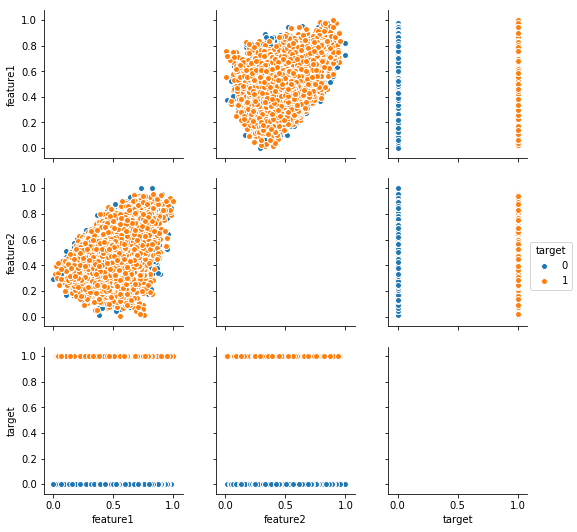

In [8]:
g0 = sns.pairplot(dataframe,vars=["feature1","feature2","target"], diag_kind="histogram",hue="target")

In [9]:
column_labels = ["V"+str(i) for i in range(1, len(dataframe.columns)+1)]
dataframe.columns =  column_labels # rename column names to be similar to R naming convention
#Features
X_raw = dataframe.loc[:, "V4":"V24"]  # independent variables data
X_raw

,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
0,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,0.69990,0.32579,0.72926,...,0.41445,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567
1,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,0.29581,0.60988,0.49206,...,0.62379,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617
2,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,0.67480,0.20389,0.64569,...,0.36862,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855
3,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,0.44721,0.26035,0.61347,...,0.56532,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122
4,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,0.52356,0.30413,0.62464,...,0.48232,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677
5,0.56606,0.33076,0.64089,0.42305,0.35935,0.35807,0.56341,0.40425,0.57429,0.32811,...,0.36072,0.42347,0.58581,0.43622,0.42998,0.58806,0.63282,0.53618,0.57049,0.63208
6,0.52572,0.58291,0.55984,0.56405,0.45821,0.51928,0.52253,0.42849,0.31066,0.55531,...,0.55230,0.46665,0.60435,0.60084,0.41892,0.53452,0.53926,0.58293,0.40478,0.35244
7,0.71130,0.93503,0.28506,0.77536,0.66179,0.64449,0.56403,0.28137,0.15377,0.75289,...,0.83538,0.70692,0.55610,0.71476,0.63258,0.27376,0.28701,0.62515,0.14051,0.07044
8,0.49799,0.62096,0.56384,0.48189,0.46138,0.60828,0.54611,0.49099,0.23214,0.63445,...,0.51252,0.44548,0.64106,0.59172,0.41474,0.54424,0.56900,0.53701,0.45458,0.36733
9,0.51398,0.60211,0.55871,0.45580,0.44696,0.51284,0.56540,0.49336,0.28239,0.63000,...,0.49924,0.44536,0.64554,0.55563,0.44078,0.53807,0.57801,0.50520,0.47426,0.39343


In [10]:
#Target
y_raw = dataframe.loc[:,"V25"]
y_raw

0         0
1         1
2         0
3         1
4         1
5         0
6         1
7         1
8         1
9         1
10        0
11        0
12        0
13        1
14        1
15        0
16        1
17        0
18        0
19        0
20        1
21        1
22        1
23        1
24        0
25        1
26        1
27        0
28        0
29        0
         ..
108375    1
108376    1
108377    1
108378    1
108379    1
108380    0
108381    1
108382    1
108383    1
108384    0
108385    1
108386    0
108387    1
108388    1
108389    0
108390    0
108391    0
108392    1
108393    0
108394    1
108395    1
108396    1
108397    0
108398    0
108399    0
108400    0
108401    1
108402    0
108403    0
108404    1
Name: V25, Length: 108405, dtype: int64

**Removal of Null values**


Now since there still exists 'NaN' values in our dataframe, and these are Null values, we have to do something about them. In here, I will just do the naive thing of replacing these NaNs with zeros as such:

In [11]:
X_raw = X_raw.fillna(value=0, axis=1)
X_raw

,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
0,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,0.69990,0.32579,0.72926,...,0.41445,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567
1,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,0.29581,0.60988,0.49206,...,0.62379,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617
2,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,0.67480,0.20389,0.64569,...,0.36862,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855
3,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,0.44721,0.26035,0.61347,...,0.56532,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122
4,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,0.52356,0.30413,0.62464,...,0.48232,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677
5,0.56606,0.33076,0.64089,0.42305,0.35935,0.35807,0.56341,0.40425,0.57429,0.32811,...,0.36072,0.42347,0.58581,0.43622,0.42998,0.58806,0.63282,0.53618,0.57049,0.63208
6,0.52572,0.58291,0.55984,0.56405,0.45821,0.51928,0.52253,0.42849,0.31066,0.55531,...,0.55230,0.46665,0.60435,0.60084,0.41892,0.53452,0.53926,0.58293,0.40478,0.35244
7,0.71130,0.93503,0.28506,0.77536,0.66179,0.64449,0.56403,0.28137,0.15377,0.75289,...,0.83538,0.70692,0.55610,0.71476,0.63258,0.27376,0.28701,0.62515,0.14051,0.07044
8,0.49799,0.62096,0.56384,0.48189,0.46138,0.60828,0.54611,0.49099,0.23214,0.63445,...,0.51252,0.44548,0.64106,0.59172,0.41474,0.54424,0.56900,0.53701,0.45458,0.36733
9,0.51398,0.60211,0.55871,0.45580,0.44696,0.51284,0.56540,0.49336,0.28239,0.63000,...,0.49924,0.44536,0.64554,0.55563,0.44078,0.53807,0.57801,0.50520,0.47426,0.39343


In [12]:
#Dimensiones de X_raw e y_raw
print("matriz X_raw MxN = ", X_raw.shape, "X_raw dimension = ",X_raw.ndim)
print("Vector y_raw N = ", y_raw.shape, "     y_raw dimension = ", y_raw.ndim)

#Number of features
features = X_raw.shape[1]
print("features = ", features)

matriz X_raw MxN =  (108405, 21) X_raw dimension =  2
Vector y_raw N =  (108405,)      y_raw dimension =  1
features =  21


Splitting the data into 70% training and 30% test subsets.

In [13]:
#Ram if Version(sklearn_version) < '0.18':
#    from sklearn.cross_validation import train_test_split
#else:
#    from sklearn.model_selection import train_test_split
#Total samples
nsamples = X_raw.shape[0]
#Splitting into train and test sets
split = 70 # training split% test (100-split)%
jindex = nsamples*70//100
#Samples in train
nsamples_train = jindex
#Samples in test
nsamples_test = nsamples - nsamples_train
print("Total number of samples: ",nsamples,"\nSamples in train set: ", nsamples_train, "\nSamples in test set: ",nsamples_test)
#RamX_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=0)
X_train = X_raw.values[:jindex, :]; y_train = y_raw.values[:jindex]; X_test = X_raw.values[jindex:, :]; y_test = y_raw.values[jindex:]
print("X_train.shape = ", X_train.shape, "y_train.shape =", y_train.shape, "\nX_test.shape =  ", X_test.shape, "y_test.shape = ", y_test.shape)
X_test[-2,]

Total number of samples:  108405 
Samples in train set:  75883 
Samples in test set:  32522
X_train.shape =  (75883, 21) y_train.shape = (75883,) 
X_test.shape =   (32522, 21) y_test.shape =  (32522,)


array([ 0.79815,  0.69102,  0.25002,  0.77749,  0.71413,  0.5184 ,
        0.3916 ,  0.23395,  0.57335,  0.57506,  0.75647,  0.77227,
        0.77176,  0.33135,  0.39728,  0.72395,  0.23857,  0.24347,
        0.48707,  0.26495,  0.28836])

In [14]:
Train = pd.DataFrame(data=X_train)
Train.columns = dataframe.columns[3:24]
print("X_train")
Train

X_train


,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
0,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,0.69990,0.32579,0.72926,...,0.41445,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567
1,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,0.29581,0.60988,0.49206,...,0.62379,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617
2,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,0.67480,0.20389,0.64569,...,0.36862,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855
3,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,0.44721,0.26035,0.61347,...,0.56532,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122
4,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,0.52356,0.30413,0.62464,...,0.48232,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677
5,0.56606,0.33076,0.64089,0.42305,0.35935,0.35807,0.56341,0.40425,0.57429,0.32811,...,0.36072,0.42347,0.58581,0.43622,0.42998,0.58806,0.63282,0.53618,0.57049,0.63208
6,0.52572,0.58291,0.55984,0.56405,0.45821,0.51928,0.52253,0.42849,0.31066,0.55531,...,0.55230,0.46665,0.60435,0.60084,0.41892,0.53452,0.53926,0.58293,0.40478,0.35244
7,0.71130,0.93503,0.28506,0.77536,0.66179,0.64449,0.56403,0.28137,0.15377,0.75289,...,0.83538,0.70692,0.55610,0.71476,0.63258,0.27376,0.28701,0.62515,0.14051,0.07044
8,0.49799,0.62096,0.56384,0.48189,0.46138,0.60828,0.54611,0.49099,0.23214,0.63445,...,0.51252,0.44548,0.64106,0.59172,0.41474,0.54424,0.56900,0.53701,0.45458,0.36733
9,0.51398,0.60211,0.55871,0.45580,0.44696,0.51284,0.56540,0.49336,0.28239,0.63000,...,0.49924,0.44536,0.64554,0.55563,0.44078,0.53807,0.57801,0.50520,0.47426,0.39343


In [15]:
Test = pd.DataFrame(data=X_test)
Test.columns = dataframe.columns[3:24]
print("X_test")
Test

X_test


,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
0,0.36398,0.41649,0.73590,0.28638,0.32455,0.50793,0.53322,0.63904,0.32090,0.57016,...,0.30421,0.27582,0.69097,0.47263,0.30021,0.71351,0.75392,0.43181,0.66889,0.56214
1,0.53222,0.52782,0.58087,0.45845,0.42571,0.46605,0.56838,0.45538,0.35477,0.54138,...,0.47427,0.44296,0.63226,0.54788,0.42769,0.55056,0.58692,0.54514,0.48400,0.44739
2,0.49202,0.51621,0.63870,0.43292,0.38463,0.53279,0.60805,0.46206,0.27575,0.51831,...,0.43906,0.39690,0.69244,0.63353,0.35677,0.60051,0.63201,0.62134,0.48629,0.45281
3,0.50720,0.52681,0.59521,0.44574,0.43347,0.52168,0.55296,0.47479,0.31705,0.56287,...,0.47161,0.42833,0.63708,0.56963,0.39232,0.56863,0.59589,0.56702,0.49132,0.44084
4,0.48680,0.58804,0.61536,0.46970,0.39077,0.50965,0.61424,0.47221,0.22957,0.57391,...,0.48333,0.40501,0.70553,0.65283,0.38086,0.58273,0.61455,0.59316,0.44673,0.38176
5,0.47691,0.58803,0.54430,0.55390,0.50403,0.54676,0.40843,0.51833,0.33758,0.65074,...,0.56195,0.45669,0.53479,0.48573,0.42788,0.54245,0.53346,0.45064,0.45861,0.33997
6,0.55131,0.60368,0.53953,0.53976,0.45903,0.59573,0.54333,0.42757,0.33172,0.54843,...,0.51092,0.48681,0.59884,0.54121,0.47929,0.50834,0.53747,0.51201,0.43610,0.39637
7,0.53531,0.55199,0.54060,0.51125,0.47727,0.47649,0.49320,0.46373,0.37898,0.58224,...,0.52756,0.47351,0.56822,0.50151,0.45288,0.52302,0.54162,0.49952,0.46482,0.40410
8,0.49588,0.49868,0.71710,0.40386,0.26798,0.43036,0.78494,0.39590,0.20120,0.41828,...,0.39619,0.34361,0.84587,0.81835,0.29259,0.64924,0.70136,0.79406,0.44002,0.46197
9,0.43662,0.60201,0.57838,0.50994,0.48145,0.62177,0.43154,0.55744,0.26011,0.67521,...,0.52522,0.41937,0.57836,0.51668,0.39115,0.57599,0.57196,0.45254,0.48416,0.34574


Standardizing the data.

In [37]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#Ram writing X_train_std as pandas dataframe Train_std for printing
Train_std = pd.DataFrame(data=X_train_std)
Train_std.columns = dataframe.columns[3:24]
#Ram writing X_train_std as pandas dataframe Train_std for printing
Test_std = pd.DataFrame(data=X_test_std)
Test_std.columns = dataframe.columns[3:24]

print("X_train_std")
Train_std

X_train_std


,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
0,-2.367464,-0.065880,0.984907,-0.211821,0.063305,2.555206,-2.253976,2.401648,-0.142012,1.690173,...,-0.574773,-1.304525,-0.624847,-1.382936,-1.143407,1.408749,0.823219,-2.154635,1.378846,-0.264236
1,2.424238,0.188126,-2.012583,1.704838,1.511354,-1.565622,-0.517154,-2.106036,2.725856,-0.755194,...,1.418109,2.245130,-1.990983,-1.426798,2.484705,-2.157406,-1.997583,-0.313619,-1.255014,-0.164761
2,-2.195838,-0.446224,1.541338,-1.134872,-0.935562,0.883199,-0.554409,2.121654,-1.372583,0.828625,...,-1.011067,-1.821969,0.801027,0.103659,-1.871152,1.796241,1.492022,-0.708384,1.323979,0.142001
3,0.212808,0.884742,-0.406571,0.764071,0.282238,-0.150024,0.245116,-0.417147,-0.802623,0.496459,...,0.861485,0.352418,0.240168,1.015556,0.119842,-0.400465,-0.481945,0.685786,-1.063359,-1.064300
4,-0.226167,0.330529,-0.048679,-0.160506,0.020280,-0.131834,-0.013459,0.434549,-0.360668,0.611614,...,0.071338,-0.122505,0.148162,-0.083236,0.050251,0.028189,0.075324,-0.462975,0.081551,-0.253815
5,0.714510,-1.899155,0.473062,-0.405269,-0.784864,-1.377304,0.289299,-0.896372,2.366577,-2.445404,...,-1.086273,-0.029319,-0.420848,-1.106179,0.248189,0.201301,0.383630,0.113016,0.838352,1.880731
6,0.275208,0.497839,-0.337192,1.030317,0.322797,0.190817,-0.121208,-0.625971,-0.294748,-0.103130,...,0.737536,0.427411,-0.213834,0.654927,0.124645,-0.365229,-0.559022,0.632151,-0.969223,-0.768527
7,2.296171,3.845169,-3.084158,3.181760,2.603777,1.408759,0.295525,-2.267117,-1.878540,1.933782,...,3.432411,2.968832,-0.752584,1.873643,2.511291,-3.124443,-3.100534,1.100984,-3.851896,-3.440143
8,-0.026771,0.859551,-0.297204,0.193808,0.358315,1.056537,0.115577,0.071226,-1.087401,0.712748,...,0.358837,0.203489,0.196063,0.557361,0.077953,-0.262377,-0.259380,0.122233,-0.426001,-0.627462
9,0.147360,0.680358,-0.348488,-0.071826,0.196748,0.128174,0.309283,0.097663,-0.580131,0.666872,...,0.232414,0.202220,0.246086,0.171270,0.368828,-0.327664,-0.168601,-0.231002,-0.211331,-0.380195


In [38]:
ytrain = pd.DataFrame(data=y_train)
ytrain

,0
0,0
1,1
2,0
3,1
4,1
5,0
6,1
7,1
8,1
9,1


In [39]:
#Write to TSV file the principal components/scores with reduced dimension
outputfile = os.path.join(os.environ['DATA_PATH'],'processed','2017week32','numerai_datasets','numerai_std_TRAIN.tsv')
np.savetxt(outputfile, Train_std, delimiter='\t')
outputfile = os.path.join(os.environ['DATA_PATH'],'processed','2017week32','numerai_datasets','numerai_std_TEST.tsv')
np.savetxt(outputfile, Test_std, delimiter='\t')

---

**Note**

Becareful not to write `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 samples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify samples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these samples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify samples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- sample5: -18.37 -> class 2
- sample6: -17.15 -> class 2
- sample7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new samples" are much lower than every standardized feature in the training set.

---

Eigendecomposition of the covariance matrix.

In [42]:
cov_mat = np.cov(X_train_std.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

#Ram print('\nEigenvalues \n%s' % eigen_vals)
eigen_vals_dataframe = pd.DataFrame(data=eigen_vals)
eigen_vals_dataframe.columns = ["Lambda"]
print("Eigenvalues")
eigen_vals_dataframe

Eigenvalues


,Lambda
0,1.220630e+01
1,4.544826e+00
2,3.408026e+00
3,4.399740e-01
4,2.854092e-01
5,9.652853e-02
6,1.921552e-02
7,7.591257e-10
8,7.758442e-10
9,1.035522e-09


In [43]:
print("Eigenvectors")
eigen_vecs_dataframe = pd.DataFrame(data=eigen_vecs)
column_labels = ["EV"+str(i) for i in range(1, len(eigen_vecs_dataframe.columns)+1)]
row_labels = ["V"+str(i) for i in range(4, len(eigen_vecs_dataframe.columns)+4)]
eigen_vecs_dataframe.columns = column_labels  # rename column names to be similar to R naming convention
eigen_vecs_dataframe.index = row_labels
eigen_vecs_dataframe

Eigenvectors


,EV1,EV2,EV3,EV4,EV5,EV6,EV7,EV8,EV9,EV10,...,EV12,EV13,EV14,EV15,EV16,EV17,EV18,EV19,EV20,EV21
V4,-0.202229,0.303562,-0.140408,-0.105326,-0.167625,0.135740,-0.087176,0.048683,-0.034494,-0.082908,...,-0.468450,0.060001,-0.031311,-0.062415,0.216639,-0.287720,0.031919,0.121458,0.552112,0.145931
V5,-0.230670,-0.075412,0.295415,0.013599,-0.287832,-0.185911,0.103232,-0.325465,0.579930,-0.017624,...,0.000663,0.460503,-0.021438,0.040856,-0.143862,0.003291,0.199281,0.000780,0.025166,0.062196
V6,0.282875,-0.035303,0.050359,-0.010689,0.150209,-0.158499,0.058920,-0.103207,-0.019515,-0.000974,...,-0.008538,0.146948,-0.796160,-0.309650,0.297931,-0.040414,0.040709,-0.027365,0.038304,0.011779
V7,-0.274202,-0.015346,0.085515,0.011778,0.323999,-0.521312,-0.026496,0.029510,0.127753,0.017409,...,-0.067750,-0.486290,0.063647,-0.094135,0.098338,0.129297,0.387841,0.236551,0.075265,0.169747
V8,-0.270736,-0.128377,-0.063159,-0.035496,0.073478,0.389793,-0.056562,0.040574,0.050599,0.489564,...,-0.093961,0.052802,-0.033350,-0.059323,0.032553,-0.253502,0.267383,0.011502,-0.063879,0.101288
V9,-0.070794,-0.333980,0.177320,-0.857340,0.019668,-0.022729,0.248217,-0.032992,-0.192367,-0.035697,...,-0.069868,-0.014882,0.023587,-0.009295,-0.052979,-0.023007,-0.053116,-0.013431,0.002740,0.022856
V10,0.114907,0.393388,0.158607,-0.061046,-0.410214,-0.032925,0.023933,0.014256,-0.296969,0.021038,...,0.032610,-0.183847,-0.149711,-0.128570,-0.403377,-0.188741,0.445463,-0.037562,-0.254634,0.057916
V11,0.160380,-0.381785,0.046181,0.172310,-0.086529,0.099464,-0.093140,-0.008537,-0.013681,-0.532394,...,-0.572037,-0.046554,0.011962,-0.021543,-0.113368,-0.020272,0.086247,0.188611,-0.216112,0.008205
V12,-0.039258,0.123638,-0.510527,0.090908,0.166143,-0.131311,0.731727,-0.042364,0.011233,0.020911,...,-0.169267,0.129663,0.016769,0.010653,-0.159534,-0.116642,-0.007504,0.120146,-0.178628,0.006057
V13,-0.139192,-0.343663,0.215614,0.294896,-0.222051,0.349164,0.468574,0.051803,0.039888,-0.028234,...,0.163081,-0.402929,-0.108423,-0.050504,0.180943,-0.060716,0.068647,-0.107187,0.135392,-0.010035


 The eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [44]:
for ev in eigen_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev),decimal=5)
print('Everything ok!')


Everything ok!


**Note**: 

Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


<br>
<br>

## Total and explained variance

In [45]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("eigen_vals =",eigen_vals)

eigen_vals = [  1.22062974e+01   4.54482627e+00   3.40802579e+00   4.39974020e-01
   2.85409169e-01   9.65285346e-02   1.92155247e-02   7.59125725e-10
   7.75844224e-10   1.03552205e-09   1.02067843e-09   1.00658937e-09
   8.18933347e-10   8.35852158e-10   8.50523642e-10   8.77354359e-10
   9.79221674e-10   9.05649079e-10   9.62700436e-10   9.47072116e-10
   9.30626595e-10]


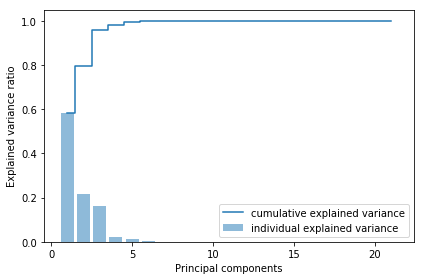

In [46]:
import matplotlib.pyplot as plt


plt.bar(range(1, features+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, features+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

<br>
<br>

## Feature transformation

In [47]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Note: I added the `key=lambda k: k[0]` in the sort call above
# just like I used it further below in the LDA section.
# This is to avoid problems if there are ties in the eigenvalue
# arrays (i.e., the sorting algorithm will only regard the
# first element of the tuples, now).

In [48]:
#Ram w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
#               eigen_pairs[1][1][:, np.newaxis],
#               eigen_pairs[2][1][:, np.newaxis]))
W = eigen_vecs
print('Matrix W:\n', W)

Matrix W:
 [[ -2.02228804e-01   3.03562476e-01  -1.40407816e-01  -1.05325893e-01
   -1.67624603e-01   1.35739589e-01  -8.71761640e-02   4.86831009e-02
   -3.44938671e-02  -8.29076857e-02   2.68449126e-01  -4.68450178e-01
    6.00013124e-02  -3.13105595e-02  -6.24146103e-02   2.16639068e-01
   -2.87720156e-01   3.19190273e-02   1.21457986e-01   5.52111650e-01
    1.45930832e-01]
 [ -2.30670025e-01  -7.54115526e-02   2.95415081e-01   1.35985462e-02
   -2.87831993e-01  -1.85911006e-01   1.03231706e-01  -3.25464995e-01
    5.79930352e-01  -1.76242222e-02   6.24866996e-02   6.62561164e-04
    4.60502549e-01  -2.14378153e-02   4.08555264e-02  -1.43861812e-01
    3.29055131e-03   1.99281195e-01   7.80174911e-04   2.51662945e-02
    6.21959093e-02]
 [  2.82874670e-01  -3.53027948e-02   5.03592118e-02  -1.06890226e-02
    1.50209446e-01  -1.58499444e-01   5.89198557e-02  -1.03207288e-01
   -1.95149421e-02  -9.73906157e-04  -8.98319343e-02  -8.53806423e-03
    1.46947689e-01  -7.96159652e-01  -3

**Note**
Depending on which version of NumPy and LAPACK you are using, you may obtain the the Matrix W with its signs flipped. 

Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have

$$\Sigma v = \lambda v,$$

where $\lambda$ is our eigenvalue,


then $-v$ is also an eigenvector that has the same eigenvalue, since

$$\Sigma(-v) = -\Sigma v = -\lambda v = \lambda(-v).$$

In [49]:
#Principal components
X_train_pca = X_train_std.dot(W)
Train_pca = pd.DataFrame(data=X_train_pca)
column_labels = ["PC"+str(i) for i in range(1, len(eigen_vecs_dataframe.columns)+1)]
Train_pca.columns = column_labels
Train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,2.155333,-6.048244,-0.169525,-0.603363,0.396429,-0.382018,0.741623,-1.841358e-05,-9.038719e-06,1.161494e-05,...,-4.104374e-05,-3.419076e-05,-1.849476e-05,2.814330e-05,-2.511450e-05,4.354267e-06,-3.697860e-06,0.000023,0.000017,0.000011
1,-6.468012,2.444385,-3.868048,0.641311,0.238590,-0.414851,0.058164,-1.651947e-05,2.597760e-05,6.841358e-06,...,-1.177588e-05,-3.654540e-05,2.430649e-05,1.398536e-05,3.241746e-05,9.164596e-06,-6.600035e-05,0.000019,0.000004,-0.000012
2,4.774916,-3.288983,1.514722,0.160281,0.088983,0.071439,-0.034356,-2.257251e-05,-3.464609e-05,1.416213e-05,...,3.965870e-06,-3.474892e-05,6.810549e-05,3.382041e-05,3.263543e-05,6.201257e-05,-7.874823e-06,0.000010,-0.000010,0.000035
3,-1.833615,0.716163,2.009706,0.459202,0.282559,-0.004823,-0.036168,-6.978652e-06,1.842955e-05,4.687999e-05,...,2.674237e-06,2.285125e-05,9.852922e-06,-4.077904e-05,1.849613e-05,-2.345001e-05,-1.546095e-05,-0.000013,0.000023,0.000014
4,0.016214,-0.714745,0.402807,0.495740,-0.570547,0.043736,-0.014425,1.667357e-05,5.059789e-05,6.210918e-06,...,2.085685e-06,3.550767e-05,1.665251e-07,2.414431e-05,8.825988e-06,-6.434127e-05,-3.807146e-05,-0.000012,0.000015,-0.000019
5,2.018641,2.290578,-4.082699,-0.296677,0.570013,-0.668499,-0.105538,2.651681e-05,1.228094e-05,-1.200159e-05,...,-1.082034e-05,2.207161e-05,4.679267e-05,-3.192554e-05,-1.659609e-05,1.430942e-05,9.987255e-05,0.000033,0.000003,0.000017
6,-1.899556,0.678769,1.081452,-0.107621,0.865185,-0.279576,-0.098126,-2.283703e-05,3.025882e-05,1.485107e-05,...,7.386005e-05,-6.373748e-06,-1.931468e-05,1.988378e-06,-2.610065e-05,5.519703e-06,-1.293869e-05,0.000009,-0.000018,-0.000004
7,-11.176727,1.742165,4.588008,-0.486259,-0.358434,0.246674,-0.074187,1.556279e-06,2.503957e-05,4.056173e-05,...,-3.851940e-05,3.661043e-05,1.014743e-06,-3.955846e-05,4.025604e-05,-9.286823e-07,-6.226741e-05,-0.000004,-0.000040,-0.000051
8,-1.102128,-0.542772,1.759388,-0.587686,-0.366351,0.272606,-0.020857,1.229497e-05,2.795642e-05,-2.621146e-05,...,-1.944778e-05,-7.137350e-07,6.360012e-06,3.744278e-05,-5.324585e-06,-2.755049e-05,3.585399e-05,-0.000020,0.000009,-0.000054
9,-0.835015,-0.192483,0.849713,0.145671,-0.879795,0.178425,0.001411,-2.720413e-05,2.912548e-05,4.314054e-06,...,-4.122115e-05,-8.851130e-06,-5.955604e-05,4.813438e-06,-1.800006e-05,-7.451903e-06,-2.683444e-05,-0.000043,-0.000036,0.000027


In [50]:
#Extended Principal components matrix with target column
Train_pca_ext = Train_pca.assign(target = y_train)
Train_pca_ext

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,target
0,2.155333,-6.048244,-0.169525,-0.603363,0.396429,-0.382018,0.741623,-1.841358e-05,-9.038719e-06,1.161494e-05,...,-3.419076e-05,-1.849476e-05,2.814330e-05,-2.511450e-05,4.354267e-06,-3.697860e-06,0.000023,0.000017,0.000011,0
1,-6.468012,2.444385,-3.868048,0.641311,0.238590,-0.414851,0.058164,-1.651947e-05,2.597760e-05,6.841358e-06,...,-3.654540e-05,2.430649e-05,1.398536e-05,3.241746e-05,9.164596e-06,-6.600035e-05,0.000019,0.000004,-0.000012,1
2,4.774916,-3.288983,1.514722,0.160281,0.088983,0.071439,-0.034356,-2.257251e-05,-3.464609e-05,1.416213e-05,...,-3.474892e-05,6.810549e-05,3.382041e-05,3.263543e-05,6.201257e-05,-7.874823e-06,0.000010,-0.000010,0.000035,0
3,-1.833615,0.716163,2.009706,0.459202,0.282559,-0.004823,-0.036168,-6.978652e-06,1.842955e-05,4.687999e-05,...,2.285125e-05,9.852922e-06,-4.077904e-05,1.849613e-05,-2.345001e-05,-1.546095e-05,-0.000013,0.000023,0.000014,1
4,0.016214,-0.714745,0.402807,0.495740,-0.570547,0.043736,-0.014425,1.667357e-05,5.059789e-05,6.210918e-06,...,3.550767e-05,1.665251e-07,2.414431e-05,8.825988e-06,-6.434127e-05,-3.807146e-05,-0.000012,0.000015,-0.000019,1
5,2.018641,2.290578,-4.082699,-0.296677,0.570013,-0.668499,-0.105538,2.651681e-05,1.228094e-05,-1.200159e-05,...,2.207161e-05,4.679267e-05,-3.192554e-05,-1.659609e-05,1.430942e-05,9.987255e-05,0.000033,0.000003,0.000017,0
6,-1.899556,0.678769,1.081452,-0.107621,0.865185,-0.279576,-0.098126,-2.283703e-05,3.025882e-05,1.485107e-05,...,-6.373748e-06,-1.931468e-05,1.988378e-06,-2.610065e-05,5.519703e-06,-1.293869e-05,0.000009,-0.000018,-0.000004,1
7,-11.176727,1.742165,4.588008,-0.486259,-0.358434,0.246674,-0.074187,1.556279e-06,2.503957e-05,4.056173e-05,...,3.661043e-05,1.014743e-06,-3.955846e-05,4.025604e-05,-9.286823e-07,-6.226741e-05,-0.000004,-0.000040,-0.000051,1
8,-1.102128,-0.542772,1.759388,-0.587686,-0.366351,0.272606,-0.020857,1.229497e-05,2.795642e-05,-2.621146e-05,...,-7.137350e-07,6.360012e-06,3.744278e-05,-5.324585e-06,-2.755049e-05,3.585399e-05,-0.000020,0.000009,-0.000054,1
9,-0.835015,-0.192483,0.849713,0.145671,-0.879795,0.178425,0.001411,-2.720413e-05,2.912548e-05,4.314054e-06,...,-8.851130e-06,-5.955604e-05,4.813438e-06,-1.800006e-05,-7.451903e-06,-2.683444e-05,-0.000043,-0.000036,0.000027,1


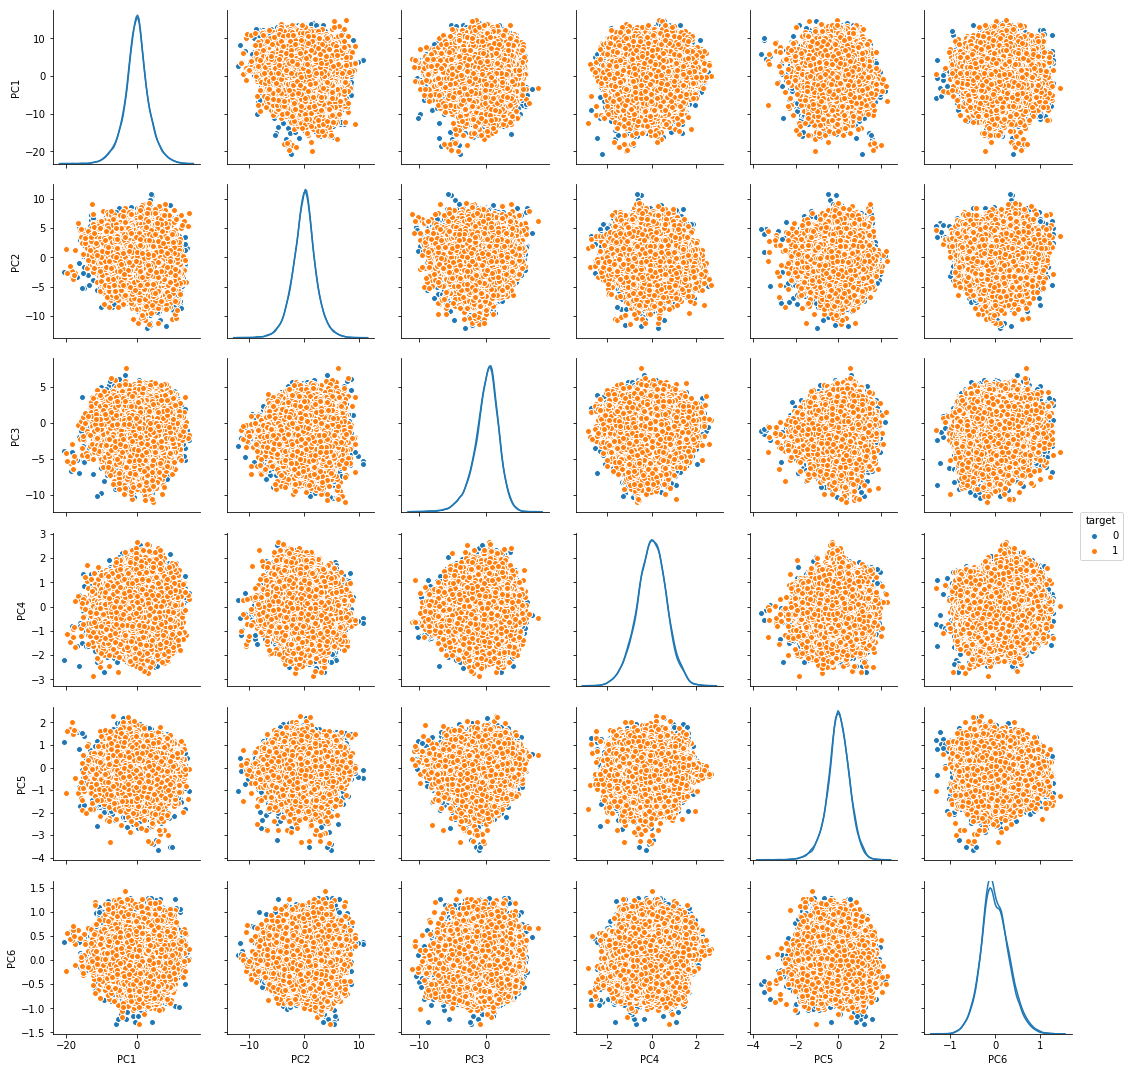

In [51]:
g1 = sns.pairplot(Train_pca_ext, vars=["PC1","PC2","PC3","PC4","PC5","PC6"], diag_kind="kde",hue="target")

In [52]:
X_train_std[0].dot(W) #First raw of transformed coordinates to principal components

array([  2.15533299e+00,  -6.04824422e+00,  -1.69525254e-01,
        -6.03363352e-01,   3.96428754e-01,  -3.82018088e-01,
         7.41623420e-01,  -1.84135804e-05,  -9.03871948e-06,
         1.16149395e-05,   3.95140117e-05,  -4.10437406e-05,
        -3.41907612e-05,  -1.84947621e-05,   2.81432980e-05,
        -2.51144971e-05,   4.35426662e-06,  -3.69785971e-06,
         2.26603387e-05,   1.65227951e-05,   1.09185712e-05])

<br>
<br>

## Principal component analysis in scikit-learn

In [53]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([  5.81244598e-01,   2.16417447e-01,   1.62284804e-01,
         2.09508677e-02,   1.35907337e-02,   4.59653631e-03,
         9.15012929e-04,   4.93099309e-11,   4.86030893e-11,
         4.79321931e-11,   4.66289708e-11,   4.58422639e-11,
         4.50980748e-11,   4.43149464e-11,   4.31255480e-11,
         4.17782311e-11,   4.05005210e-11,   3.98019550e-11,
         3.89963518e-11,   3.69444364e-11,   3.61483455e-11])

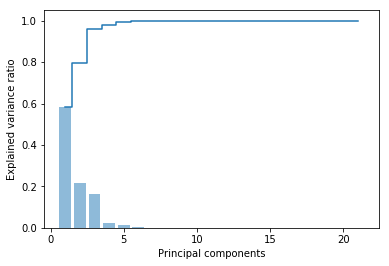

In [54]:
plt.bar(range(1, features+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, features+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [55]:
#New reduced dimension
dim_reduced = 6 #From above graphic
pca = PCA(n_components=21)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#Manage data as dataframe
Train_pca = pd.DataFrame(data=X_train_pca)
Test_pca = pd.DataFrame(data=X_test_pca)
column_labels = ["PC"+str(i) for i in range(1, len(eigen_vecs_dataframe.columns)+1)]
Train_pca.columns = column_labels
Test_pca.columns = column_labels
Train_pca
Test_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-5.366844,2.109771,0.780403,-0.108821,0.807637,0.057386,0.018584,1.191435e-05,2.049798e-05,-1.626384e-05,...,-7.232974e-05,1.970862e-05,-4.775421e-05,1.197171e-05,-0.000009,5.321056e-06,3.462677e-05,1.406797e-05,6.583040e-05,-1.364247e-05
1,0.197878,-0.816510,0.180475,-0.029633,0.177293,0.028294,-0.027144,4.732394e-05,1.621016e-05,3.618105e-05,...,-2.820250e-05,-5.809236e-05,-2.426245e-05,-2.396227e-05,0.000030,2.962414e-05,-4.755127e-05,-3.553521e-05,-5.820833e-06,6.599448e-06
2,-1.426213,-1.113624,-1.345130,0.649668,-0.271685,0.176900,-0.006829,2.170445e-05,-7.476314e-05,1.962248e-05,...,2.614105e-05,-5.521023e-05,1.265021e-05,-2.989551e-05,0.000015,-4.662126e-05,9.827425e-06,1.172777e-05,7.140909e-07,1.734263e-05
3,-0.160625,-0.334902,-0.424567,0.308800,-0.098596,0.363105,0.014746,-2.566123e-05,-3.175434e-05,-4.083943e-05,...,1.111474e-05,-6.456201e-07,3.051170e-06,-2.925559e-05,0.000015,-3.659893e-05,-1.580059e-05,-1.455680e-05,-6.515604e-05,-2.319143e-05
4,-0.482710,-0.836789,-2.260004,0.025800,0.127594,-0.118824,-0.049367,-4.260684e-05,-3.352431e-05,2.433040e-05,...,9.368734e-07,2.996369e-07,4.528248e-05,-9.463308e-06,-0.000011,-1.136546e-05,-2.038707e-05,4.760648e-06,7.523152e-05,-1.291959e-05
5,2.316445,1.934363,0.060712,-0.394437,-0.513059,-0.181422,-0.069290,-1.018930e-05,4.374120e-05,4.102957e-05,...,3.407310e-05,-2.241456e-05,1.966429e-05,-3.678920e-06,0.000013,3.775598e-07,-2.463239e-05,9.617150e-06,-1.918454e-05,4.990687e-05
6,2.118133,-0.290691,-0.254800,0.971770,0.243740,-0.527235,-0.015793,-1.720636e-05,3.938776e-05,2.816924e-05,...,1.273086e-06,3.056596e-05,4.756118e-05,-5.823223e-06,-0.000003,-9.925598e-06,-5.195281e-05,3.139645e-05,1.275980e-05,-4.188288e-05
7,1.810778,0.107950,0.660162,-0.302208,-0.100755,-0.025116,-0.064685,6.576234e-05,3.237994e-05,-3.149799e-06,...,-3.791599e-05,3.428274e-05,6.483398e-06,-1.239029e-05,-0.000015,1.035728e-05,5.126614e-05,1.460548e-05,-2.422631e-05,-3.759124e-05
8,-3.887800,-4.311395,-3.637655,0.442093,-0.574768,-0.076575,0.015848,-1.371919e-05,-8.949287e-06,-1.610904e-05,...,-1.252678e-05,-8.681035e-06,3.068488e-05,7.435858e-06,-0.000023,5.019528e-05,2.800206e-05,-7.072667e-05,-2.599146e-06,3.117914e-05
9,1.104163,2.547210,-0.972540,0.118132,-0.160439,-0.003550,-0.072883,-6.081491e-06,4.854338e-05,-3.901975e-05,...,1.015180e-05,-9.568287e-06,-2.200165e-05,6.471161e-05,0.000018,-3.539611e-06,-1.262972e-05,7.320581e-05,3.903547e-05,3.579124e-05


In [56]:
#Extended Principal components matrix with target column
Train_pca_ext = Train_pca.assign(target = y_train)
Test_pca_ext = Test_pca.assign(target = y_test)
#Move last column to first one
cols = Train_pca_ext.columns.tolist()
cols = cols[-1:] + cols[:-1]
Train_pca_ext = Train_pca_ext[cols]
Test_pca_ext = Test_pca_ext[cols]
Train_pca_ext

#Test_pca_ext

,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,0,-2.155333,6.048244,0.169525,0.603363,-0.396429,-0.382018,0.741623,1.161494e-05,3.951434e-05,...,0.000023,0.000017,0.000011,3.697894e-06,2.511440e-05,-2.814311e-05,1.849512e-05,3.419106e-05,-9.039158e-06,-1.841328e-05
1,1,6.468012,-2.444385,3.868048,-0.641311,-0.238590,-0.414851,0.058164,6.841844e-06,3.649572e-05,...,0.000019,0.000004,-0.000012,6.600047e-05,-3.241693e-05,-1.398670e-05,-2.430697e-05,3.654424e-05,2.597752e-05,-1.651947e-05
2,0,-4.774916,3.288983,-1.514722,-0.160281,-0.088983,0.071439,-0.034356,1.416198e-05,1.013923e-05,...,0.000010,-0.000010,0.000035,7.875264e-06,-3.263547e-05,-3.382352e-05,-6.810492e-05,3.474505e-05,-3.464538e-05,-2.257345e-05
3,1,1.833615,-0.716163,-2.009706,-0.459202,-0.282559,-0.004823,-0.036168,4.687952e-05,-4.612722e-05,...,-0.000013,0.000023,0.000014,1.546083e-05,-1.849583e-05,4.077874e-05,-9.853667e-06,-2.285126e-05,1.843018e-05,-6.978824e-06
4,1,-0.016214,0.714745,-0.402807,-0.495740,0.570547,0.043736,-0.014425,6.211053e-06,4.540718e-07,...,-0.000012,0.000015,-0.000019,3.807158e-05,-8.825497e-06,-2.414397e-05,-1.647811e-07,-3.550747e-05,5.059770e-05,1.667417e-05
5,0,-2.018641,-2.290578,4.082699,0.296677,-0.570013,-0.668499,-0.105538,-1.200247e-05,-3.425487e-05,...,0.000033,0.000003,0.000017,-9.987237e-05,1.659659e-05,3.192340e-05,-4.679352e-05,-2.207360e-05,1.228148e-05,2.651625e-05
6,1,1.899556,-0.678769,-1.081452,0.107621,-0.865185,-0.279576,-0.098126,1.485195e-05,-4.464675e-08,...,0.000009,-0.000018,-0.000004,1.293851e-05,2.610082e-05,-1.987652e-06,1.931515e-05,6.374768e-06,3.025882e-05,-2.283635e-05
7,1,11.176727,-1.742165,-4.588008,0.486259,0.358434,0.246674,-0.074187,4.056218e-05,2.589262e-05,...,-0.000004,-0.000040,-0.000051,6.226704e-05,-4.025554e-05,3.955892e-05,-1.015506e-06,-3.660990e-05,2.504017e-05,1.556271e-06
8,1,1.102128,0.542772,-1.759388,0.587686,0.366351,0.272606,-0.020857,-2.621164e-05,1.327406e-05,...,-0.000020,0.000009,-0.000054,-3.585395e-05,5.324647e-06,-3.744360e-05,-6.359106e-06,7.132110e-07,2.795612e-05,1.229523e-05
9,1,0.835015,0.192483,-0.849713,-0.145671,0.879795,0.178425,0.001411,4.314292e-06,3.769223e-05,...,-0.000043,-0.000036,0.000027,2.683456e-05,1.799999e-05,-4.810760e-06,5.955648e-05,8.853983e-06,2.912537e-05,-2.720297e-05


In [57]:
#Principal components matrix after reduce dimension
cols_red = cols[:dim_reduced+1]
Train_pca_red = Train_pca_ext[cols_red]
Test_pca_red = Test_pca_ext[cols_red]
Train_pca_red
#Test_pca_red

,target,PC1,PC2,PC3,PC4,PC5,PC6
0,0,-2.155333,6.048244,0.169525,0.603363,-0.396429,-0.382018
1,1,6.468012,-2.444385,3.868048,-0.641311,-0.238590,-0.414851
2,0,-4.774916,3.288983,-1.514722,-0.160281,-0.088983,0.071439
3,1,1.833615,-0.716163,-2.009706,-0.459202,-0.282559,-0.004823
4,1,-0.016214,0.714745,-0.402807,-0.495740,0.570547,0.043736
5,0,-2.018641,-2.290578,4.082699,0.296677,-0.570013,-0.668499
6,1,1.899556,-0.678769,-1.081452,0.107621,-0.865185,-0.279576
7,1,11.176727,-1.742165,-4.588008,0.486259,0.358434,0.246674
8,1,1.102128,0.542772,-1.759388,0.587686,0.366351,0.272606
9,1,0.835015,0.192483,-0.849713,-0.145671,0.879795,0.178425


In [58]:
#Write to file the principal components/scores with reduced dimension
outputfile = os.path.join(os.environ['DATA_PATH'],'processed','2017week32','numerai_datasets','numerai_pca_TRAIN')
np.savetxt(outputfile, Train_pca_red, delimiter=',')   # X is an array
outputfile = os.path.join(os.environ['DATA_PATH'],'processed','2017week32','numerai_datasets','numerai_pca_TEST')
np.savetxt(outputfile, Test_pca_red, delimiter=',')   # X is an array

In [59]:
#Write to TSV file the principal components/scores with reduced dimension
outputfile = os.path.join(os.environ['DATA_PATH'],'processed','2017week32','numerai_datasets','numerai_pca_TRAIN.tsv')
np.savetxt(outputfile, Train_pca_red, delimiter='\t')   # X is an array
outputfile = os.path.join(os.environ['DATA_PATH'],'processed','2017week32','numerai_datasets','numerai_pca_TEST.tsv')
np.savetxt(outputfile, Test_pca_red, delimiter='\t')   # X is an array

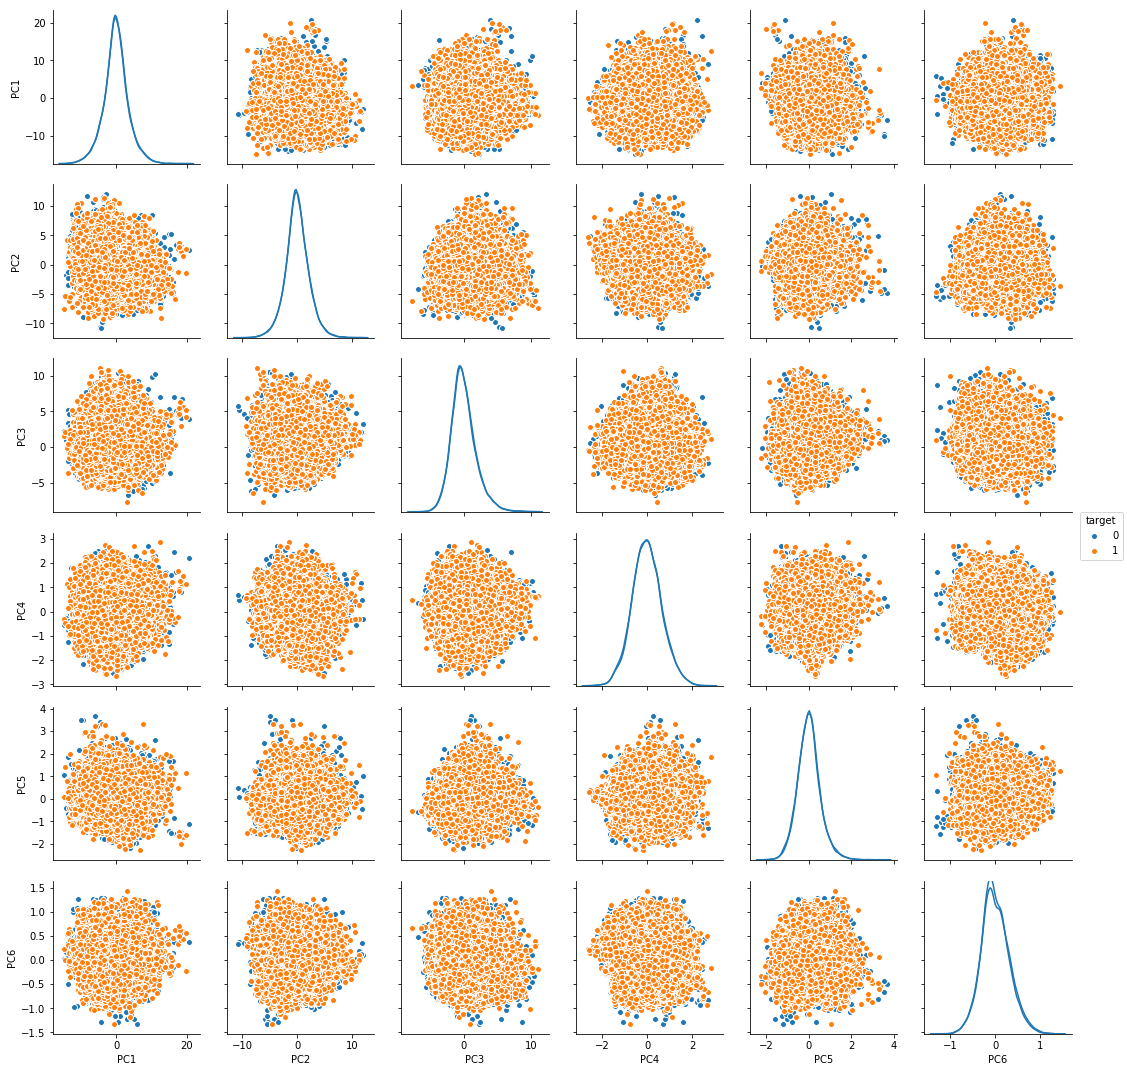

In [60]:
g2 = sns.pairplot(Train_pca_ext, vars=["PC1","PC2","PC3","PC4","PC5","PC6"], diag_kind="kde",hue="target")

In [64]:
#Ram code from: https://stackoverflow.com/questions/38503381/set-number-of-lags-in-python-pandas-autocorrelation-plot
from pandas.compat import lmap


def autocorrelation_plot(series, n_samples=None, ax=None, **kwds):
    """Autocorrelation plot for time series.

    Parameters:
    -----------
    series: Time series
    ax: Matplotlib axis object, optional
    kwds : keywords
        Options to pass to matplotlib plotting method
    n_samples: number of lags plotted
    Returns:
    -----------
    ax: Matplotlib axis object
    """
    import matplotlib.pyplot as plt
    n = len(series)
    data = np.asarray(series)
    if ax is None:
        ax = plt.gca(xlim=(1, n_samples), ylim=(-1.0, 1.0))
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) *
                (data[h:] - mean)).sum() / float(n) / c0
    x = (np.arange(n) + 1).astype(int)
    y = lmap(r, x)
    z95 = 1.959963984540054
    z99 = 2.5758293035489004
    ax.axhline(y=z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.axhline(y=z95 / np.sqrt(n), color='grey')
    ax.axhline(y=0.0, color='black')
    ax.axhline(y=-z95 / np.sqrt(n), color='grey')
    ax.axhline(y=-z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    if n_samples:
        ax.plot(x[:n_samples], y[:n_samples], **kwds)
    else:
        ax.plot(x, y, **kwds)
    if 'label' in kwds:
        ax.legend()
    ax.grid()
    return ax

In [111]:
Test_std["V4"]

0       -1.486138
1        0.345993
2       -0.091784
3        0.073526
4       -0.148630
5       -0.256332
6        0.553883
7        0.379643
8       -0.049749
9       -0.695089
10       1.981777
11       0.811540
12       0.420263
13      -0.505713
14       0.329876
15       2.148939
16      -0.348788
17      -2.903687
18       0.391295
19      -0.537620
20       0.476999
21      -1.189821
22      -2.110570
23       0.074832
24       0.626628
25       0.176545
26      -0.098427
27      -0.041908
28       0.845299
29      -0.043215
           ...   
32492   -0.240106
32493   -1.826341
32494    0.025065
32495   -0.256114
32496    0.035084
32497    1.069850
32498    0.298077
32499    0.928607
32500   -0.269182
32501    0.293939
32502   -0.887407
32503    1.885946
32504   -0.610692
32505   -1.287614
32506   -0.200466
32507    0.547893
32508   -0.022633
32509   -0.136869
32510    0.485494
32511    1.094897
32512    0.573920
32513    0.035955
32514    0.315501
32515   -1.235559
32516    0

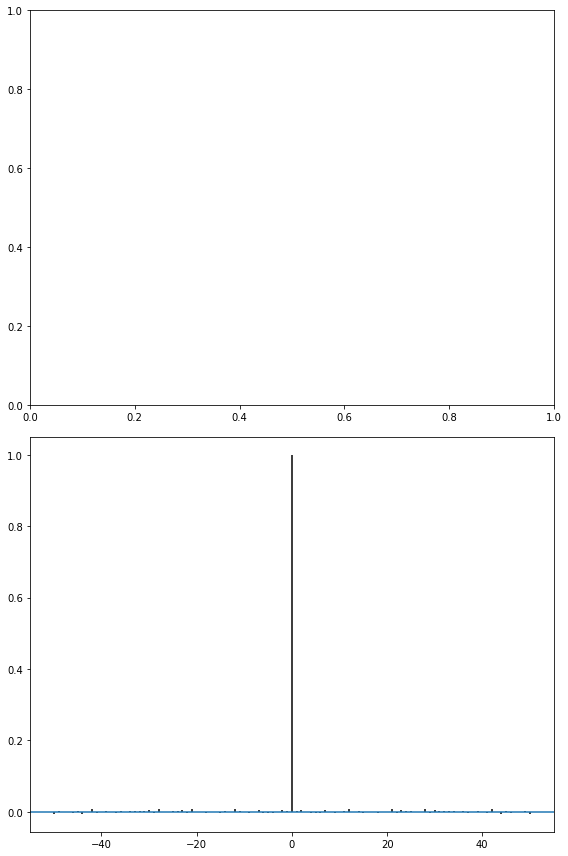

In [140]:
from pandas import Series
from matplotlib import pyplot
from pandas.plotting import lag_plot#, autocorrelation_plot
#Ram series = Series.from_csv('daily-minimum-temperatures.csv', header=0)
#Ram autocorrelation_plot(Test_pca["PC1"], n_samples=10)
#Ra lag_plot(Train_pca["PC1"])
fig, axes = plt.subplots(nrows=2, figsize=(8, 12))
fig.tight_layout()
axes[1].acorr(Train_std["V4"], maxlags=50)
pyplot.show()

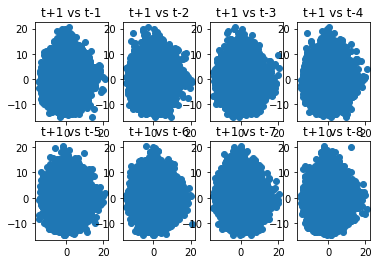

In [132]:
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from pandas.tools.plotting import scatter_matrix
#Ram series = Series.from_csv('daily-minimum-temperatures.csv', header=0)
#Ram values = DataFrame(series.values)
values = Train_pca["PC1"]
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
	ax = pyplot.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

In [ ]:
#Dimensionality reduction with t-distributed Stochastic Neighbor Embedding.
#X_embedded = TSNE(n_components=3, perplexity=50.0).fit_transform(X_train)
#X_embedded.shape

In [188]:
#Raw_embedded = pd.DataFrame(data=X_embedded)
#column_labels = ["TSNE"+str(i) for i in range(1, len(Raw_embedded.columns)+1)]
#Raw_embedded.columns = column_labels
#Raw_embedded

,TSNE1,TSNE2,TSNE3
0,-9.259808,3.300651,8.951793
1,11.539756,-4.329564,7.030238
2,-14.621568,0.595695,4.603393
3,8.194374,7.987201,-7.461527
4,-1.558894,4.772097,-1.747778
5,-3.087945,-10.133298,3.492354
6,9.269534,4.090399,-5.276915
7,18.074558,0.514235,9.033187
8,3.090882,9.627977,-5.860490
9,4.074702,6.872409,-6.013756


In [189]:
#Extended Principal components matrix with target column
Raw_embedded_ext = Raw_embedded.assign(target = y_raw)
Raw_embedded_ext

,TSNE1,TSNE2,TSNE3,target
0,-9.259808,3.300651,8.951793,0
1,11.539756,-4.329564,7.030238,1
2,-14.621568,0.595695,4.603393,0
3,8.194374,7.987201,-7.461527,1
4,-1.558894,4.772097,-1.747778,1
5,-3.087945,-10.133298,3.492354,0
6,9.269534,4.090399,-5.276915,1
7,18.074558,0.514235,9.033187,1
8,3.090882,9.627977,-5.860490,1
9,4.074702,6.872409,-6.013756,1


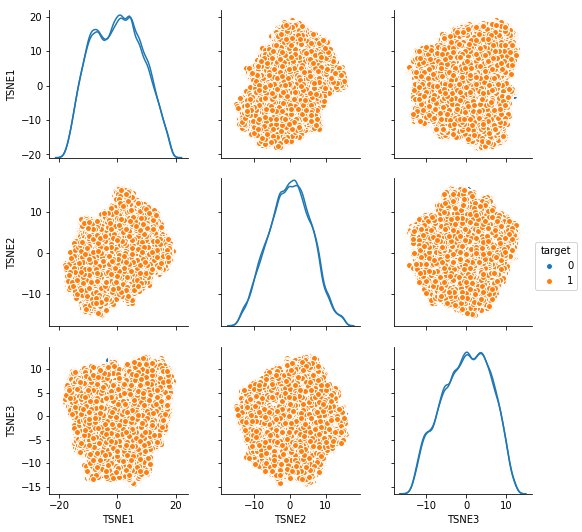

In [190]:
g3 = sns.pairplot(Raw_embedded_ext, vars=["TSNE1","TSNE2","TSNE3"], diag_kind="kde",hue="target")

In [ ]:
#Support Vector Machine
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
#Ram iris = datasets.load_iris()

# Take the first two features. We could avoid this by using a two-dim dataset
#X = iris.data[:, :2]
X = X_embedded[:, :2]

#y = iris.target
y = y_train

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()